In [ ]:
import numpy as np 
import pandas as pd 
import cv2
import keras
from numpy import random
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D
from keras.layers import MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from keras.applications import MobileNet, VGG16, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report ,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
from keras.applications import VGG16
from keras.models import Model
from keras.layers import *

In [2]:
# Directory of train, validation and test

train_folder = "/kaggle/input/chest-ctscan-images/Data/train"
valid_folder = "/kaggle/input/chest-ctscan-images/Data/valid"
test_folder = "/kaggle/input/chest-ctscan-images/Data/test"


In [ ]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)
val_datagen = ImageDataGenerator(
    dtype='float32',

)
test_datagen = ImageDataGenerator(
    dtype='float32',
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
)


test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
    shuffle = False,
)
validation_generator = val_datagen.flow_from_directory(
    valid_folder,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [ ]:
def squeeze_excitation_block(input, ratio=16):
    """
    Adds a Squeeze-and-Excitation (SE) block to the input tensor.

    This block applies channel-wise attention to recalibrate feature maps,
    allowing the model to emphasize informative features and suppress less useful ones.

    Parameters:
    ----------
    input : tf.Tensor
        Input tensor of shape (batch_size, height, width, channels).
    ratio : int, optional (default=16)
        Reduction ratio for the bottleneck in the excitation phase.

    Returns:
    -------
    tf.Tensor
        Output tensor after applying SE block, with the same shape as the input.

    Process:
    -------
    1. Squeeze: Global Average Pooling is applied to each channel.
    2. Excitation: Two dense layers generate weights for each channel.
    3. Recalibration: The original input is scaled by the generated weights.
    """

    init = input
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x


In [ ]:
def residual_block(x, filters, kernel_size, stride):
    """
    Creates a Residual Block with Squeeze-and-Excitation (SE) mechanism.

    This block performs two convolutional layers with batch normalization
    and ReLU activation, followed by a squeeze-and-excitation block.
    A residual connection is added between the input and the output
    to allow better gradient flow and improve training.

    Parameters:
    ----------
    x : tf.Tensor
        Input tensor of shape (batch_size, height, width, channels).
    filters : int
        Number of filters for the convolutional layers.
    kernel_size : int or tuple
        Size of the convolutional kernels.
    stride : int or tuple
        Stride for the first convolution layer.

    Returns:
    -------
    tf.Tensor
        Output tensor after applying the residual block with SE mechanism.

    Process:
    -------
    1. Conv2D → BN → ReLU
    2. Conv2D → BN
    3. Squeeze-and-Excitation block
    4. Add shortcut connection
    5. ReLU activation
    """

    shortcut = x  # Save the original input to add later

    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    x = squeeze_excitation_block(x)  # Add channel-wise attention

    x = Add()([x, shortcut])  # Add residual connection
    x = Activation('relu')(x)

    return x


In [ ]:
input_tensor = Input(shape=(224, 224, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

x = vgg16.layers[-1].output
x = residual_block(x, 512, 3, 1)
x = residual_block(x, 512, 3, 1)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=predictions)
model.summary()

optimizer = tf.keras.optimizers.SGD()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 100
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 50,447,684 (192.44 MB)

 Trainable params: 50,442,564 (192.42 MB)

 Non-trainable params: 5,120 (20.00 KB)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727881021.533300      89 service.cc:145] XLA service 0x7ccea4002030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727881021.533384      89 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1727881058.522806      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.4177 - loss: 1.5391 - val_accuracy: 0.1806 - val_loss: 7.6698
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 599ms/step - accuracy: 0.5353 - loss: 1.0916 - val_accuracy: 0.1806 - val_loss: 6.9538
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 592ms/step - accuracy: 0.5249 - loss: 1.0797 - val_accuracy: 0.1806 - val_loss: 4.1484
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 594ms/step - accuracy: 0.6407 - loss: 0.8238 - val_accuracy: 0.1806 - val_loss: 5.8786
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 549ms/step - accuracy: 0.6589 - loss: 0.7905 - val_accuracy: 0.2917 - val_loss: 1.8679
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 599ms/step - accuracy: 0.6039 - loss: 0.9395 - val_accuracy: 0.3333 - val_loss: 1.9158
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 598ms/step - accuracy: 0.6636 - loss: 0.7469 - val_accuracy: 0.4167 - val_loss: 1.2719
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 627ms/step - accuracy: 0.6981 - loss: 0.6618 - val_accuracy: 0

In [5]:
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test accuracy:', test_accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.9508 - loss: 0.2819
Test accuracy: 0.9460317492485046


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 555ms/step


Confusion Matrix:
 [[112   4   0   4]
 [  1  50   0   0]
 [  3   0  51   0]
 [  5   0   0  85]]


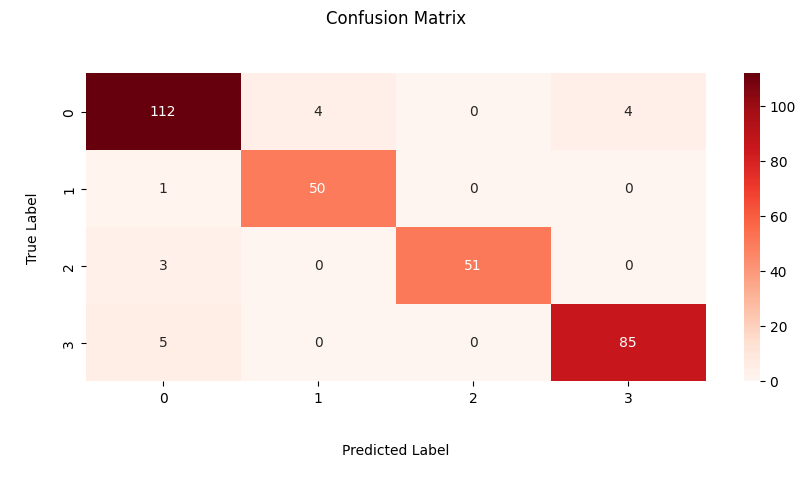

In [6]:
num_test_samples = len(test_generator)
num_classes = len(test_generator.class_indices)
predicted_probabilities = model.predict(test_generator, steps=num_test_samples)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
true_labels = test_generator.classes
cm = confusion_matrix(true_labels, predicted_labels)
print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds')
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

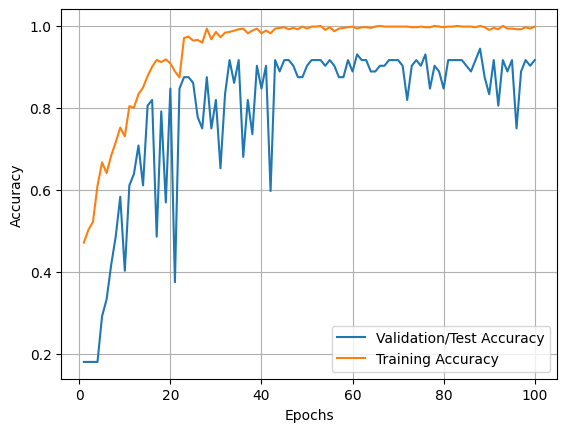

In [7]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

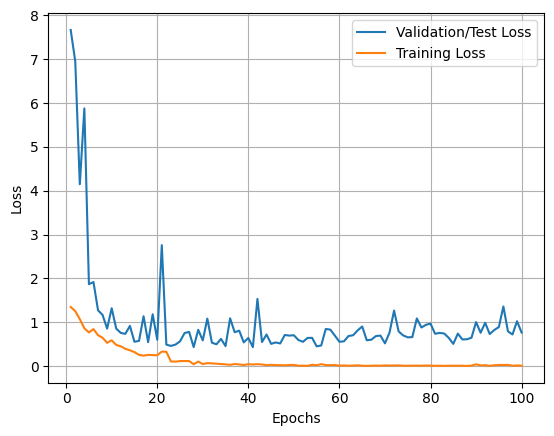

In [8]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       120
           1       0.93      0.98      0.95        51
           2       1.00      0.94      0.97        54
           3       0.96      0.94      0.95        90

    accuracy                           0.95       315
   macro avg       0.95      0.95      0.95       315
weighted avg       0.95      0.95      0.95       315



In [10]:
model.save('/kaggle/working/model_VGG16.h5')